In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision
import os
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import torchvision.utils as tutils
import imageio
import pickle
import copy
from PIL import Image
import h5py 
from torch.utils.data import Dataset, DataLoader
from matplotlib.pyplot import imshow

In [180]:
# Helper routines
IS_CUDA = False
if torch.cuda.is_available():
    IS_CUDA = True
    
def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def generate_animation(root, epoch, name):
    images = []
    for e in range(epoch):
        img_name = root+'/image_'+str(e)+'.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(root+ '/' + name +'.gif', images, fps=5)

def drawLossPlot(generatorLoss, discriminatorLoss, showPlot = False, savePlot = True, loc = ""):
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Vanilla GAN Loss')
    plt.plot(generatorLoss, label='Generator Loss')
    plt.plot(discriminatorLoss, label='Discriminator Loss')
    legend = plt.legend(loc='upper right', shadow=True)
    
    if showPlot:
        plt.show()
    if savePlot:
        plt.savefig(loc+'Loss_Plot_Vanilla_GAN_'+str(num_epochs)+'.png')

def save_image(pic, path):
    grid = torchvision.utils.make_grid(pic, nrow=8, padding=2)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

class LossModule: 
    def __init__(self):
        self.D_loss = []
        self.G_loss = []

    def insertDiscriminatorLoss(self, lossVal):
        self.D_loss.append(lossVal)
    
    def insertGeneratorLoss(self, lossVal):
        self.G_loss.append(lossVal)
    
    def getDiscriminatorLoss(self):
        return self.D_loss
    
    def getGeneratorLoss(self):
        return self.G_loss
    

In [210]:
s1 = np.array(dset[:,:,:])
s1.shape
#s1[0]
s1 = np.swapaxes(s1,1,3)
print s1.shape

(2500, 3, 64, 64)


In [129]:
dataSet1='dataHD5_Keras/train_0.h5'

In [227]:
hf = h5py.File('dataHD5_Keras/train_0.h5', 'r')
print hf.keys()

# Data Shape 
syn1 = hf['data_1']
syn2 = hf['data_2']
dlabel = hf['label']
syn1 = np.array(dset[:,:,:]) #np.swapaxes(np.array(dset[:,:,:]), 1, 3)
syn2 = np.array(dset2[:,:,:]) #np.swapaxes(np.array(dset2[:,:,:]), 1, 3)
label = np.array(dlabel)
print label.shape
print syn1.shape
print syn2.shape

[u'data_1', u'data_2', u'label']
(2500, 27)
(2500, 64, 64, 3)
(2500, 64, 64, 3)


In [228]:
image = Image.fromarray(syn1[100].astype('uint8'))
image1 = Image.fromarray(syn2[0].astype('uint8'))
#image.save(file)
#image.show()
#image1.show()

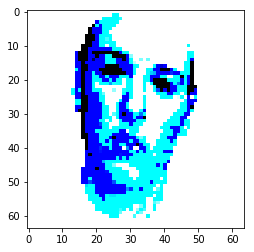

In [229]:
imshow(syn1[100])

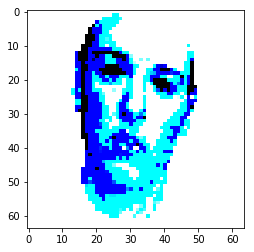

In [230]:
imshow(syn2[100])

In [231]:
# loading data
syn1 = torch.utils.data.DataLoader(hf['data_1'], batch_size=100, shuffle=True)
syn2 = torch.utils.data.DataLoader(hf['data_2'], batch_size=100, shuffle=True)
slabel = torch.utils.data.DataLoader(hf['label'], batch_size=100, shuffle=True)

In [232]:
out = next(iter(data_loader))
#out.type

In [264]:
# Resnet == Feature Net
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = conv3x3(3, 16) 
        #, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        #x = self.fc(x)

        return x

In [265]:
featureNet = ResNet(BasicBlock, [2, 2, 2, 2], 27)

In [266]:
print featureNet

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [275]:
loss = nn.MSELoss()
def train(featureNet, num_epochs = 10):
    for s1, s2, l in zip(syn1, syn2, slabel):
        #print s1.type
        #print s1.shape
        batchSize = s1.shape[0]
        #print batchSize
        s1 = var(s1)
        l = var(l)
        s1 = s1.transpose(1, 3)
        output = featureNet(s1)
        #Floss = loss(output, l)
        #Floss.backward()
    return featureNet

In [276]:
train(featureNet, )

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b